In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
def get_latent_theta(adata: ad.AnnData) -> np.ndarray:
    X = adata.obsm['X_latent']
    theta = -np.arctan2(-X[:, 1], X[:, 0]) + np.pi
    return theta

In [3]:
adata = sc.read_h5ad(os.path.join('..', 'data', 'modeling', 'training_latent.h5ad'))
adata

AnnData object with n_obs × n_vars = 140799 × 723
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight'
    obsm: 'X_diff', 'X_diffmap', 'X_latent', 'X_pca', 'X_pca_harmony', 'X_umap', 'velocity_umap'


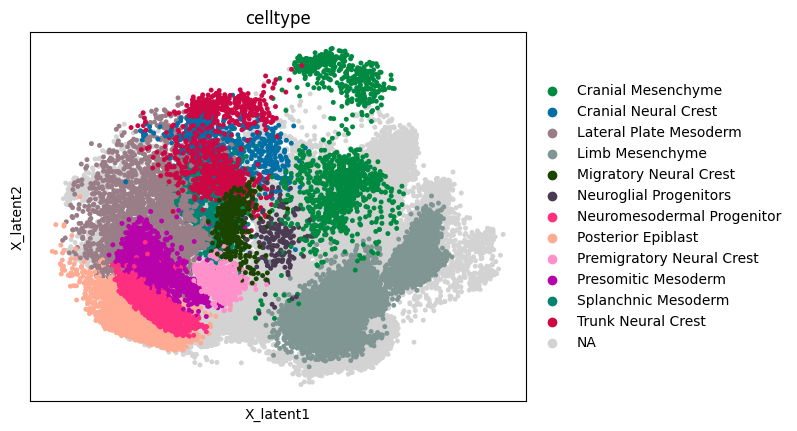

In [4]:
ms = 50; traj_celltype = adata[adata.obs.trajectory].obs.celltype.unique()
sc.pl.embedding(adata, 'X_latent', color = 'celltype', groups = traj_celltype, size = ms, show = False)
plt.gca().invert_yaxis(); plt.show()

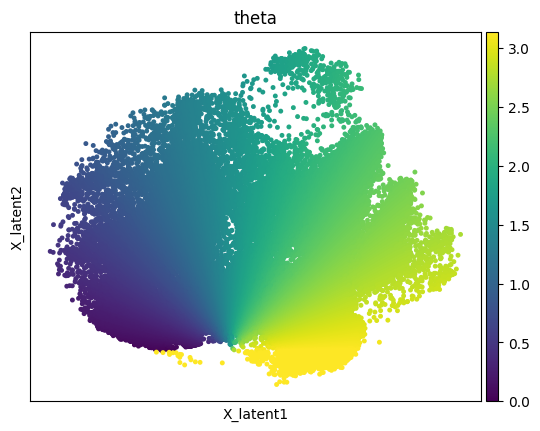

In [5]:
tlim = [0, np.pi]; adata.obs['theta'] = get_latent_theta(adata)
sc.pl.embedding(adata, 'X_latent', color = 'theta', size = ms, show = False, cmap = 'viridis', vmin = tlim[0], vmax = tlim[1])
plt.gca().invert_yaxis(); plt.show()

/tmp/ipykernel_830109/3950046145.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  theta_df = adata.obs.groupby('celltype').theta.mean().sort_values()


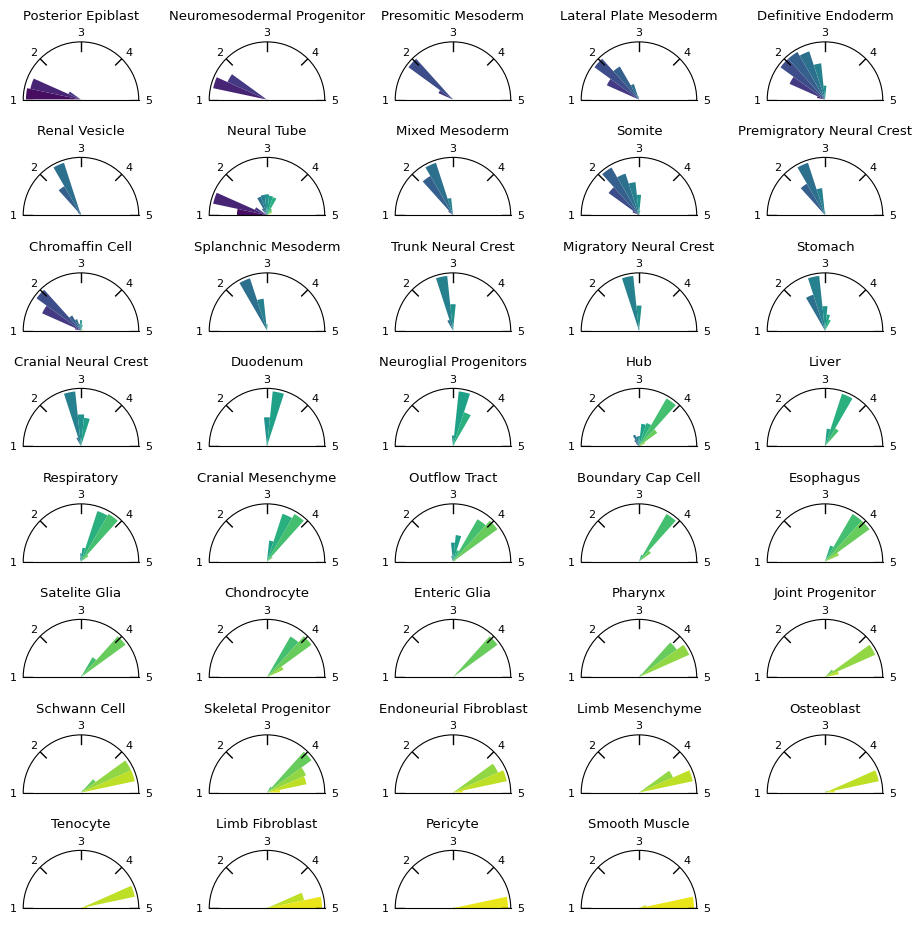

In [6]:
nbins, ncol, xticklim, cmap = 15, 5, [1, 5], plt.cm.viridis
theta_df = adata.obs.groupby('celltype').theta.mean().sort_values()
remove = theta_df.index.str.contains('Neuron|Ectoderm', regex = True)
theta_df = theta_df.loc[~remove]
nrow = theta_df.size // ncol + 1
bins = np.linspace(*tlim, nbins + 1)
locs = (bins[:-1] + bins[1:]) / 2
widths = np.diff(bins)
norm = Normalize(*tlim)
colors = [cmap(norm(l)) for l in locs]
xtickdiff = xticklim[1] - xticklim[0]
xticks = np.linspace(*tlim, xtickdiff + 1)
xticklabels = (xticklim[0] + (xtickdiff * xticks) / np.pi).astype(int)

fig, ax = plt.subplots(nrow, ncol, figsize = (12, 12), subplot_kw = {'projection' : 'polar'})
for i in range(nrow * ncol):
    row_i, col_i = i // ncol, i % ncol
    ax_i = ax[row_i, col_i]

    if i < theta_df.size:
        celltype_i = theta_df.index[i]
        msk_i = adata.obs.celltype.isin([celltype_i])
        theta_i = adata[msk_i].obs.theta.values
        counts_i, _ = np.histogram(theta_i, bins = bins)
        bars_i = ax_i.bar(locs, counts_i, width = widths, bottom = 0)

        for b, c in zip(bars_i, colors):
            b.set_facecolor(c)
        
        ax_i.set_theta_zero_location('W')
        ax_i.set_theta_direction(-1)
        ax_i.set_thetamin(0)
        ax_i.set_thetamax(180)
        ax_i.set_yticks([])
        ax_i.set_xticks(xticks, xticklabels, fontsize = 8)
        ax_i.tick_params('x', pad = -3.5)
        ax_i.set_title(celltype_i, y = .875, size = 9.5)
        ax_i.grid(False)

        ytop = ax_i.get_ylim()[1]
        ytickloc = [.85 * ytop, ytop]
        for theta in xticks:
            ax_i.plot([theta] * 2, ytickloc, c = 'k', lw = 1)
        ax_i.set_ylim(top = ytop)

    else:
        ax_i.set_visible(False)

fig.subplots_adjust(wspace = 0, hspace = 0)
plt.show()

In [ ]:
# # To-do: ???

# theta = adata.obs.theta.values
# msk_theta = (theta > tlim[0]) & (theta < tlim[1])
# ix_bin = pd.cut(theta[msk_theta], bins, labels = np.arange(nbins))
# ncells_bin = np.bincount(ix_bin, minlength = nbins - 1)
# X_mean_bin = np.zeros((adata.shape[1], nbins))
# for i, var in enumerate(adata.var_names):
#     weights = np.exp(adata[msk_theta, var].layers['MesNet'].flatten())
#     var_sum_bin = np.bincount(ix_bin, weights = weights, minlength = nbins - 1)
#     X_mean_bin[i] = np.log1p(var_sum_bin / ncells_bin)

In [ ]:
# import seaborn as sns

# sns.clustermap(X_mean_bin, col_cluster = False, figsize = (3, 20))

In [ ]:
# ncol, topn = 10, adata.shape[1]
# nrow = topn // ncol + 1
# # ix_var = Sx.argsort()[:topn]
# ix_var = X_mean_bin.argmax(1).argsort()
# # ix_var = ix_var[sort_var]

# fig, ax = plt.subplots(nrow, ncol, figsize = (20, 60), subplot_kw = {'projection' : 'polar'})
# for i in range(nrow * ncol):
#     row_i, col_i = i // ncol, i % ncol
#     ax_i = ax[row_i, col_i]

#     if i < topn:
#         var_i = adata.var_names[ix_var[i]]
#         X_mean_i = X_mean_bin[ix_var[i]]
#         bars_i = ax_i.bar(locs, X_mean_i, width = widths, bottom = 0)

#         for b, c in zip(bars_i, colors):
#             b.set_facecolor(c)
        
#         ax_i.set_theta_zero_location('W')
#         ax_i.set_theta_direction(-1)
#         ax_i.set_thetamin(0)
#         ax_i.set_thetamax(180)
#         ax_i.set_yticks([])
#         ax_i.set_xticks(xticks, xticklabels, fontsize = 8)
#         ax_i.tick_params('x', pad = -3.5)
#         ax_i.set_title(var_i, y = .875, size = 9.5)
#         ax_i.grid(False)

#         ytop = ax_i.get_ylim()[1]
#         ytickloc = [.85 * ytop, ytop]
#         for theta in xticks:
#             ax_i.plot([theta] * 2, ytickloc, c = 'k', lw = 1)
#         ax_i.set_ylim(top = ytop)

#     else:
#         ax_i.set_visible(False)

# fig.subplots_adjust(wspace = 0, hspace = 0)
# plt.show()